In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay, ConvexHull
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_rgba
import matplotlib.patches as patches
import os
import scipy.linalg as sclinalg
import copy

In [26]:
'''
Parameters
'''
radius = 1
res = 40
rho = 6.371e6
R = 1.496e11
alpha = 30/180*np.pi
beta = 30/180*np.pi


sigma = 0.001
nwater = 1.33
epsilon = 0.000000001

day = 24
Ndays = 365
year = Ndays*day
omega_day =  2*np.pi/day 
omega_year = 2*np.pi/year


delta_t = 1
delta_phi = np.pi/res
delta_theta = np.pi/res
delta_Omega = delta_phi*delta_theta 

hours = np.arange(0, day)
time_array = hours.copy()

N_ave = 187

for i in range(1, Ndays):
    time_array = np.append(time_array, hours + i*year/Ndays)

time_res = len(time_array)
print(time_res)

8760


In [3]:
'''
creating functions for albedo matrix

'''
def observabledomain(cos_theta_i,cos_theta_r):
    if cos_theta_i >= 0 and cos_theta_r >= 0:
        return 1
    else:
        return 0    
def deltapeak(x,sigma):
    delta = np.exp(-(x)**2/(2*sigma))/np.sqrt(2*np.pi*sigma)
    return delta


def create_sphere1(r, res):
    '''
    creates points on a sphere in the form:
        [[ x1.  y1.  z1.]
         ....
         [ xn.  yn.  zn.]]
    '''
    phi = np.linspace(0, 2*np.pi, 2*res)
    theta = np.linspace(0, np.pi, res)

    theta, phi = np.meshgrid(theta, phi)  
    
    theta_flat = np.ndarray.flatten(theta, order = 'C')
    phi_flat = np.ndarray.flatten(phi, order = 'C')
    
    r_pre = r*np.sin(theta_flat)
    x = np.cos(phi_flat)*r_pre
    y = np.sin(phi_flat)*r_pre
    z = r*np.cos(theta_flat)

    ''' 
    flatten arrays, delete top- end bottom points of circle and append both points once
    '''
#    x = np.delete(x, [0, res-1], 1)
#    x = np.ndarray.flatten(x, order ='F') 
#    x = np.append(x, [0,0])
#    y = np.delete(y, [0, res-1], 1)
#    y = np.ndarray.flatten(y, order = 'F') 
#    y= np.append(y, [0,0])
#    z = np.delete(z, [0, res-1], 1)
#    z = np.ndarray.flatten(z, order = 'F') 
#    z= np.append(z, [1,-1])
    

    coordinates = np.vstack((x,y,z)).transpose() # coordinates is (#points, 3) shaped

    return coordinates, theta, phi





def pnt_in_cvex_hull(hull, pnt):
    '''
    Checks if `pnt` is inside the convex hull.
    '''
    new_hull = ConvexHull(np.concatenate((hull.points, [pnt])))
    if np.array_equal(new_hull.vertices, hull.vertices): 
        return True
    else:
        return False




def height(p, vertices, seeds, altitudes):
    max_dist = 0
    '''
    finding shortest edge
    '''
    for i in range(3):
        for j in range(i+1 , 4):
            dist = np.linalg.norm(vertices[i] - vertices[j])
            if dist > max_dist:
                max_dist = dist
                furthest = np.array([i, j])   
   
    '''
    reordering everything
    '''          
    vertices[[0, furthest[0]]] = vertices[[furthest[0], 0]]
    vertices[[1, furthest[1]]] = vertices[[furthest[1], 1]]
    
    seeds[[0,furthest[0]]] = seeds[[furthest[0], 0]]
    seeds[[1,furthest[1]]] = seeds[[furthest[1], 1]]
    
    altitudes[[0, furthest[0]]] = altitudes[[furthest[0], 0]]
    altitudes[[1, furthest[1]]] = altitudes[[furthest[1], 1]]
    
    '''
    creating new edge
    new altitude = average altitude + random(-0,05; 0,05)*sqrt(distance)
    '''
    v_new = (vertices[0]+vertices[1])/2
    s_new = (seeds[0]+seeds[1])/2
    random.seed(s_new)
    a_new = (altitudes[0]+ altitudes[1])/2 + 0.01*(random.random()- 0.5)*max_dist**1.5

    
    '''
    finding in which tetrahedon our point p is
    '''    
    tetra = np.copy(vertices)
    tetra[1] = v_new
    hull = ConvexHull(tetra)
    
    if pnt_in_cvex_hull(hull, p):
        vertices[1] = v_new
        seeds[1] = s_new
        altitudes[1] = a_new
    else:
        vertices[0] = v_new
        seeds[0] = s_new
        altitudes[0] = a_new 
    
    '''
    stop if resolution is great enough
    '''
    if max_dist < 0.001:
#        print(np.sum(altitudes)/4)
        return np.sum(altitudes)/4
    else:
#        print(vertices)
#        print(seeds)
#        print(altitudes)
        
        height(p, vertices, seeds, altitudes)
    return np.sum(altitudes)/4


def polar(polarcaps, sphere,alts, p_ice):
    minz = min(sphere[:,2])
    maxz = max(sphere[:,2])
    rowdivide = np.linspace(minz,maxz,100)
    rangez = abs(maxz - minz)
    
    iceval = max(alts)

    for i in range(len(alts)):
        if abs(maxz-sphere[i,2])/rangez < p_ice or abs(minz-sphere[i,2])/rangez < p_ice:
            alts[i] = iceval
    return alts

def lambsmooth(A):
    m = max(A)
    for i in range(len(A)):
        a= A[i]
        if a <= 0.2*m:
            a = 0
        elif a <= 0.4*m:
            a = 0.125
        elif a <=  0.6*m:
            a = 0.15
        elif a <= 7*m:
            a = 0.3
        else:
            a = 0.8*0.9
        A[i] = a
    return A

In [4]:
'''
Euler rotation matrices
'''
def positive(arg):
    return (arg + abs(arg))/2

def y_rotation(angle):
    Y = np.array([[np.cos(angle), 0, np.sin(angle)],[0, 1, 0],[-np.sin(angle), 0, np.cos(angle)]])
    return Y

def z_rotation(angle):
    Z = np.array([[np.cos(angle), -np.sin(angle), 0],[np.sin(angle), np.cos(angle), 0], [0, 0, 1]])
    return Z



R_equinox = z_rotation(alpha)
R_tilt = y_rotation(beta)
R_axial = np.matmul(R_tilt,R_equinox)


In [55]:
'''
Initialize transfromation matrices (edge-on, face-on)
'''
T = np.zeros((time_res, 2*res**2)) 


Tlamb = np.zeros((time_res, 2*res**2))
Tglint = np.zeros((time_res, 2*res**2))
Tmetal = np.zeros((time_res, 2*res**2))
Tseel = np.zeros((time_res, 2*res**2))

Tlambglint = np.zeros((time_res, 2*res**2))
Tlambglintseel = np.zeros((time_res, 2*res**2))
                          
T1 = T.copy()

'''
Observer

'''
o_vec = np.array([1, 0, 0])
o_vec_1 = np.array([0, 0, 1])

In [27]:
'''
load in Transformation matrix and reflectivity maps

'''
print(alpha,beta)
filename1 = 'NEWTmatrices_res'+str(res)+'_tres'+str(time_res)+'_a'+str(alpha)+'_b'+str(beta)+'.npz'
loaded1 = np.load(filename1)
Tlambv = loaded1['lamb']
Tglintv = loaded1['glint']
Tseelv = loaded1['seel']

filename2 = 'V2Reflectivities_planet'+str(2)+'_res'+str(res)+'.npz'
loaded2  = np.load(filename2)

albedo_map = loaded2['lamb']
ocean_map = loaded2['glint']
seeliger_map = loaded2['seel']
albedo_pseudo = loaded2['pseudo']

albedo_pseudo_grid = albedo_pseudo.reshape((res,2*res), order = 'F')

print(np.max(Tglintv))

0.5235987755982988 0.5235987755982988
0.042120221606112465


In [28]:
'''
Compute light curves
'''

#f_curve_edge = np.matmul(T, albedo_map)*rho**2/(R**2)
#f_curve_face = np.matmul(T1, albedo_map)*rho**2/(R**2)

f_lamb_edge = np.matmul(Tlambv, albedo_map)*rho**2/(R**2)
f_glint_edge = 2*np.matmul(Tglintv, ocean_map)*rho**2/(R**2)
f_seel_edge  = 2*np.matmul(Tseelv, seeliger_map)*rho**2/(R**2)


f_total = f_lamb_edge+f_glint_edge+f_seel_edge

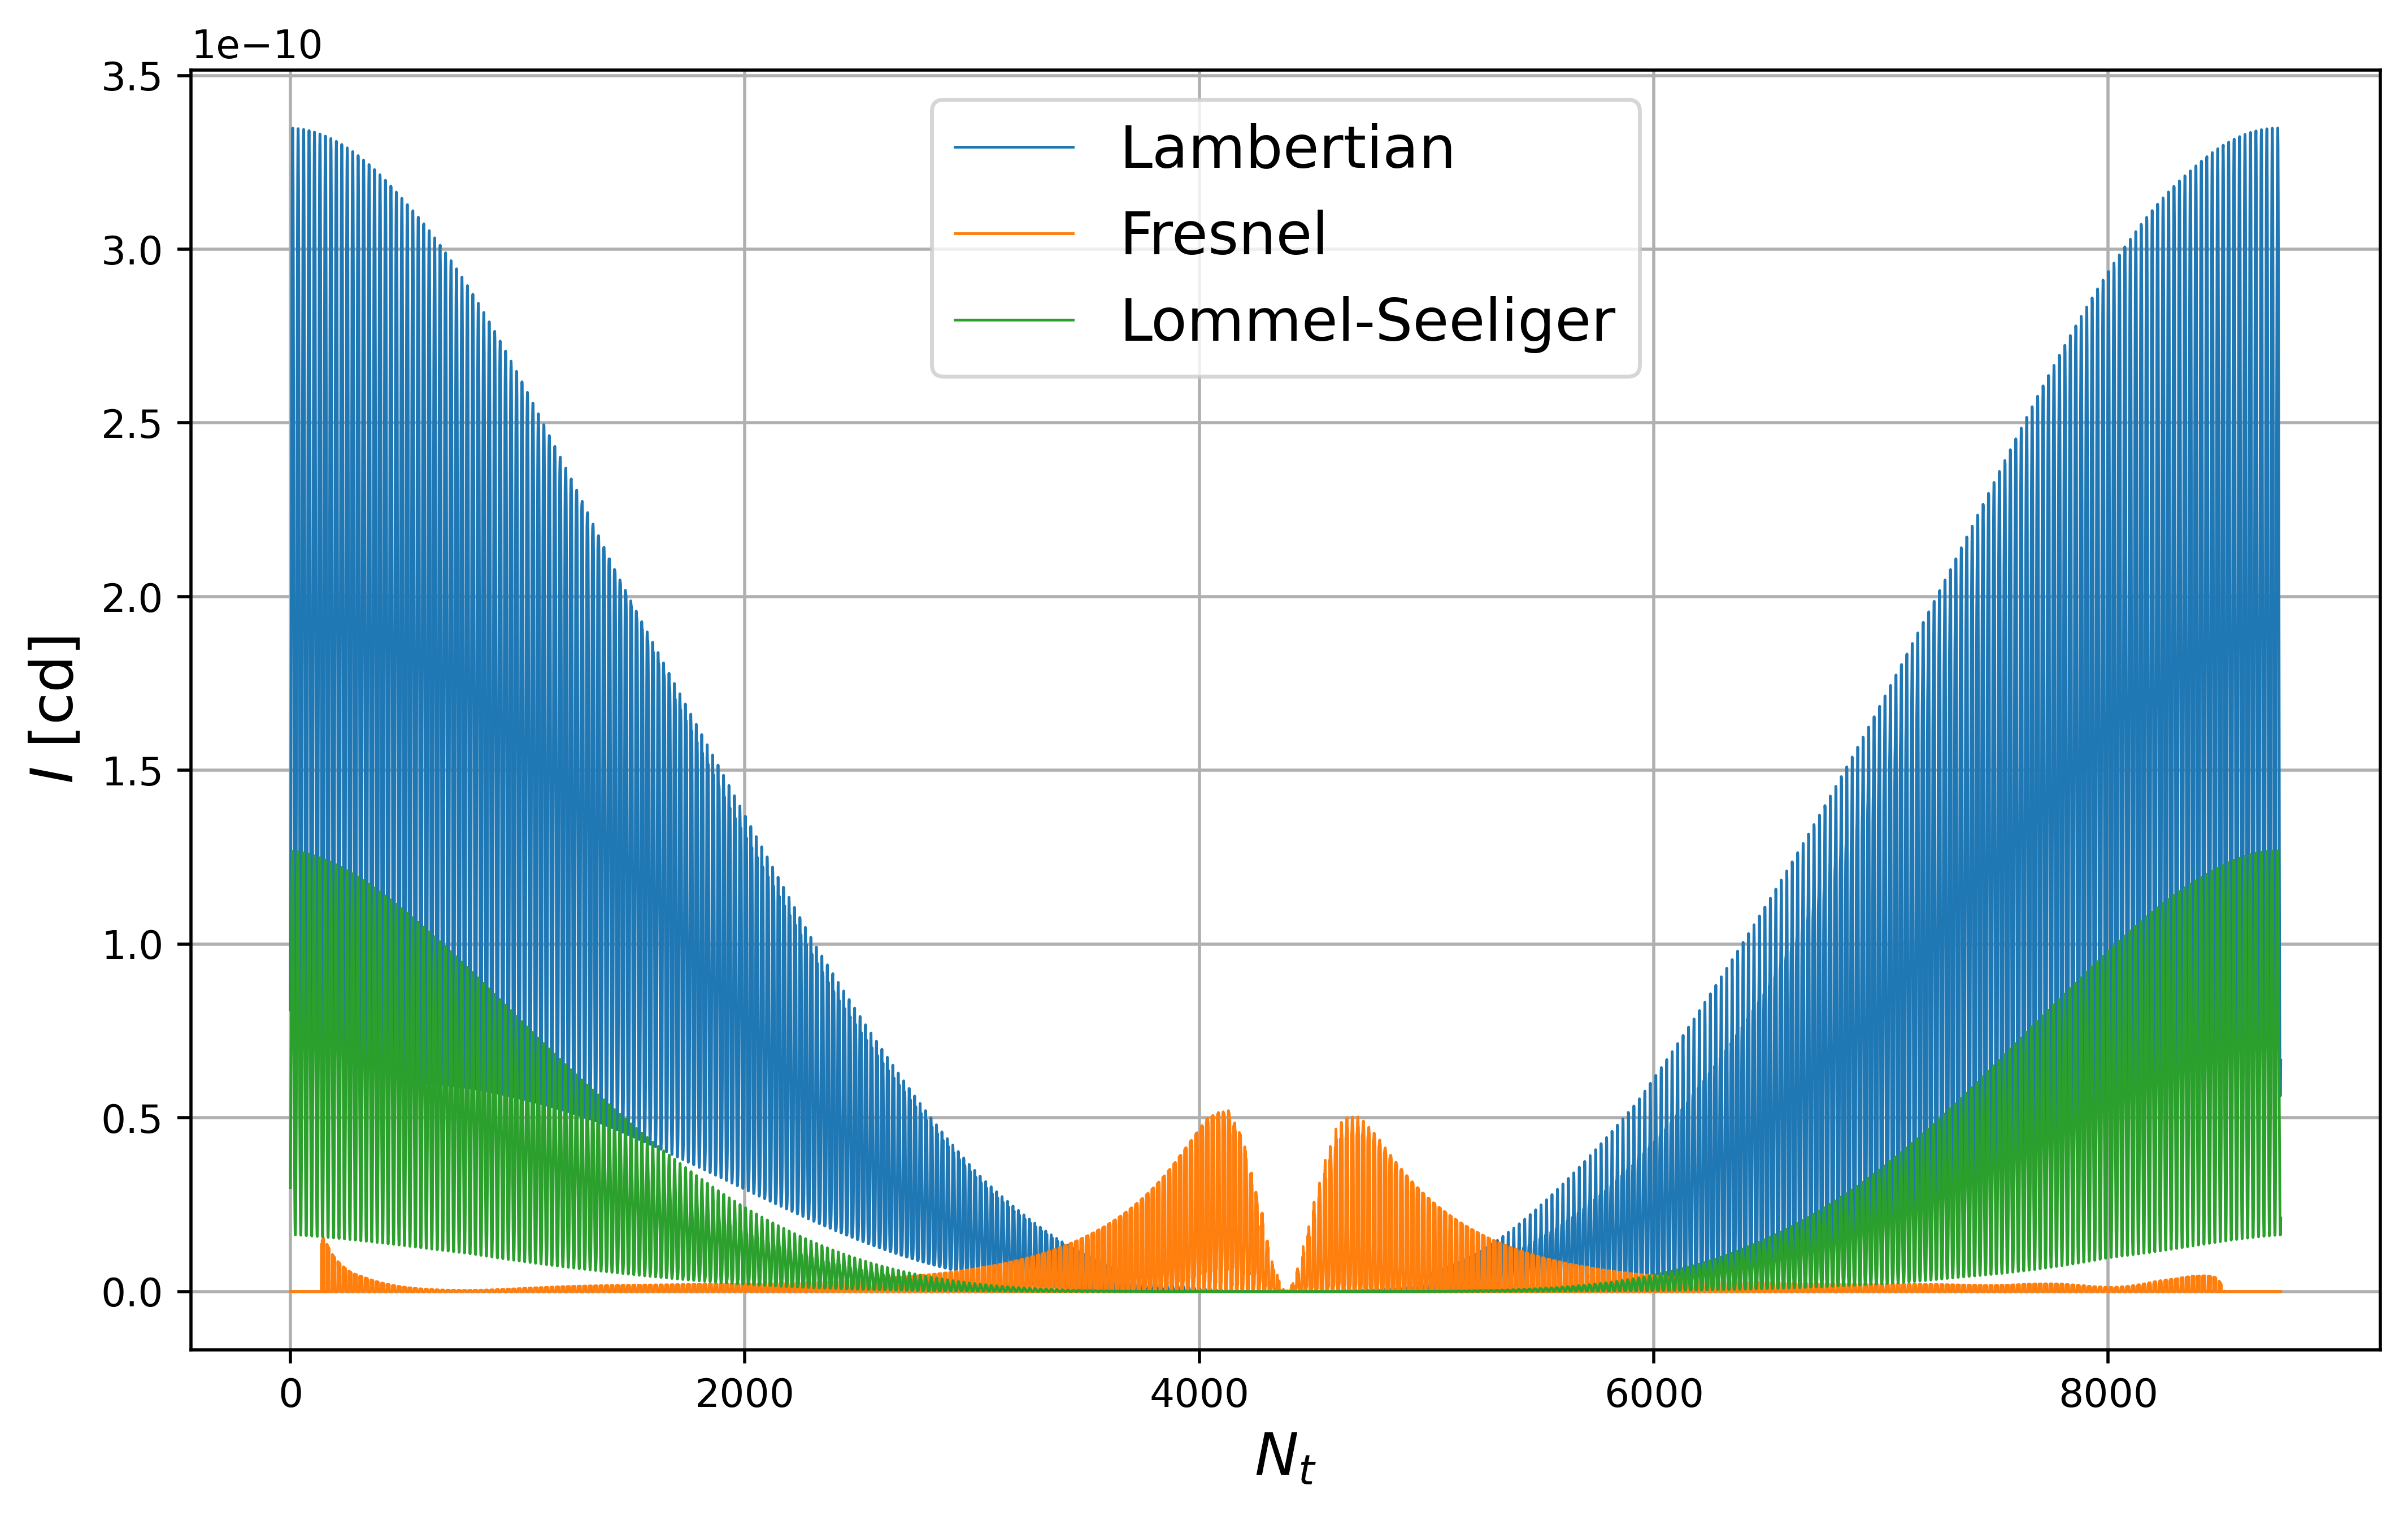

In [29]:
%matplotlib inline
f,ax=plt.subplots(figsize=(10,6), dpi=500)

#ax.plot(time_array,f_curve_edge, '-',label= 'Edge-on old')

ax.plot(time_array,f_lamb_edge, '-', linewidth = 0.7,label= 'Lambertian', alpha = 1)
#ax.plot(time_array,f_metal_edge, '-',label= '')
ax.plot(time_array,f_glint_edge, '-', linewidth = 0.7,label= 'Fresnel', alpha = 1)
ax.plot(time_array,f_seel_edge, '-', linewidth = 0.7,label= 'Lommel-Seeliger', alpha = 1)
#ax.plot(time_array,f_total, '-',label= 'Edge-on total', alpha = 1)

plt.xlabel(r'$N_t$',fontsize = 15)
plt.ylabel(r'$I$ [cd]',fontsize = 15)
#plt.title('')
plt.legend(prop={'size': 15})
plt.grid()
plt.show()

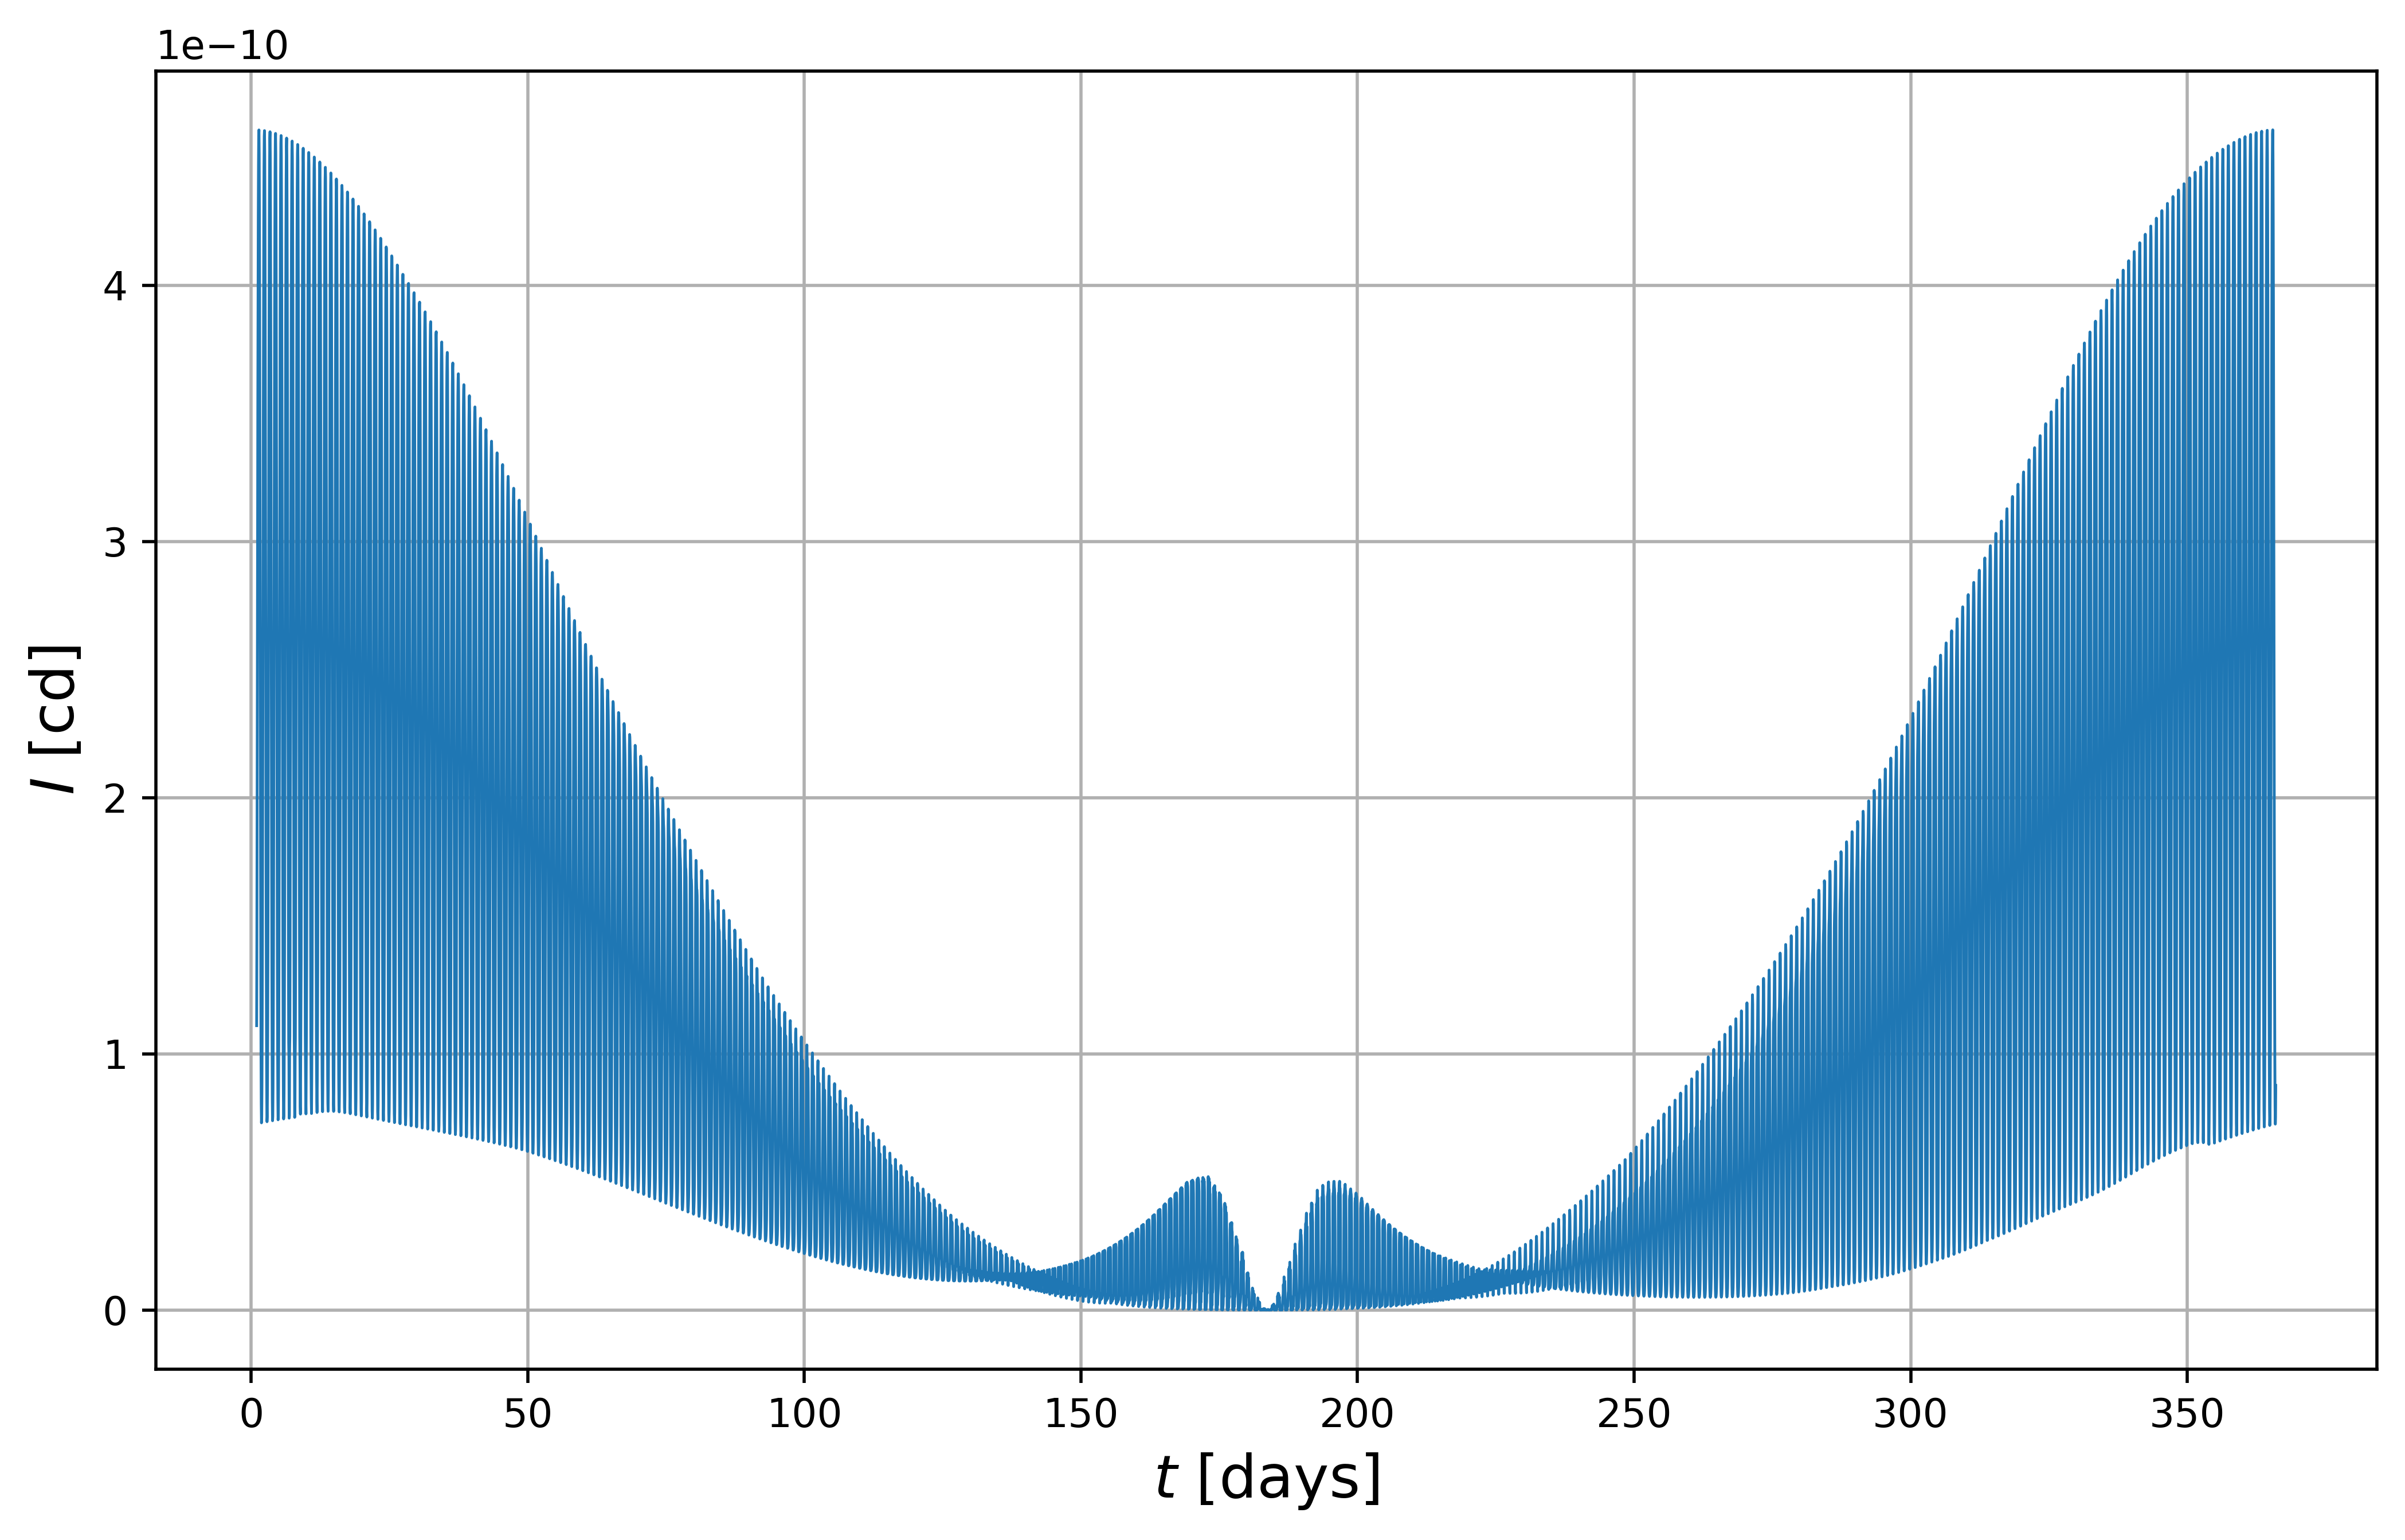

In [30]:
%matplotlib inline
f,ax=plt.subplots(figsize=(10,6), dpi=500)

daysaxis = np.linspace(1,365+1, num = len(time_array))

#ax.plot(daysaxis,f_lamb_edge, '-',label= 'Lambertian', alpha = 0.5)
#ax.plot(time_array,f_metal_edge, '-',label= '')
#ax.plot(daysaxis,f_glint_edge, '-',label= 'Fresnel', alpha = 0.5)
#ax.plot(daysaxis,f_seel_edge, '-',label= 'Lommel-Seeliger', alpha = 0.5)
ax.plot(daysaxis,f_total, '-', linewidth = 0.7, label= 'Composite', alpha = 1)

plt.xlabel(r'$t$ [days]',fontsize = 15)
plt.ylabel(r'$I$ [cd]',fontsize = 15)
#plt.title('')
#plt.legend(prop={'size': 15})
plt.grid()
plt.show()

In [9]:
# # alleen lambertian

# #nieuwe code

# Tcomp = Tlambv

# SVD_T = np.linalg.svd(Tcomp, compute_uv=False)
# print(max(SVD_T),np.mean(SVD_T))
# SVCR = 0.0001
# Tcomp_pinv_edge = np.linalg.pinv(Tcomp)

# Acomp_edge = np.matmul(Tcomp_pinv_edge, f_lamb_edge)

# print(np.shape(Acomp_edge))

# A_lamb = Acomp_edge

# lamb_factor = 0.8*0.9/(max(A_lamb)-min(A_lamb))


# A_lamb_scaled = (A_lamb-min(A_lamb))*lamb_factor




# reconstruct_A_lamb_scaled = A_lamb_scaled.reshape((res,2*res),order = 'F')

# %matplotlib inline
# albedo_map_grid = reconstruct_A_lamb_scaled

# shrink = 0.9

# lon = np.linspace(-np.pi,np.pi,2*res)
# lat = np.linspace(-np.pi/2,np.pi/2,res)
# Lon,Lat = np.meshgrid(lon,lat)


# fig1 = plt.figure(1, figsize = (10,5))

# ax1 = fig1.add_subplot(111, projection = 'mollweide')
# ax1.title.set_text('Retrieved Lambertian, alpha ='+str(round(alpha/(np.pi/6)))+'pi/6'+', beta = '+str(round(beta/(np.pi/6)))+'pi/6')
# im1 = ax1.pcolormesh(Lon,Lat, np.flipud(albedo_map_grid),cmap = 'gray')
# plt.colorbar(im1,shrink = 0.75, aspect=40,orientation = 'horizontal')
# tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
# tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
             
# fig1.show()



In [10]:
# #nieuwe code lambertian & seeliger

# Tcomp = np.concatenate((Tlambv,Tglintv),axis = 1)

# SVCR = 1e-9
# Tcomp_pinv_edge = np.linalg.pinv(Tcomp ,rcond = SVCR)

# Acomp_edge = np.matmul(Tcomp_pinv_edge, f_lambglint)

# print(np.shape(Acomp_edge))

# A_lamb = Acomp_edge[:2*res*res]
# A_glint = Acomp_edge[2*res*res:]



# lamb_factor = 0.8*0.9/(max(A_lamb)-min(A_lamb))
# glint_factor = 0.1/(max(A_glint)-min(A_glint))

# A_lamb_scaled = (A_lamb-min(A_lamb))*lamb_factor
# A_glint_scaled = (A_glint-min(A_glint))*glint_factor


# reconstruct_A_lamb_scaled = A_lamb_scaled.reshape((res,2*res),order = 'F')
# reconstruct_A_glint_scaled = A_glint_scaled.reshape((res,2*res),order = 'F')


# %matplotlib inline
# albedo_map_grid = reconstruct_A_lamb_scaled
# ocean_map_grid = reconstruct_A_glint_scaled

# shrink = 0.5


# newgistearth = cm.get_cmap('gist_earth', 4096)
# newcolors = np.vstack((newgistearth(np.linspace(0,0.35,256)), newgistearth(np.linspace(0.45,1,256))))
# newcmp = ListedColormap(newcolors)

# albedo_colors = np.vstack((newgistearth(np.linspace(0.15,0.22,100)), newgistearth(np.linspace(0.45,0.55,200)),newgistearth(np.linspace(0.6,0.7,200)),newgistearth(np.linspace(0.7,0.8,200)), newgistearth(np.linspace(0.95,1,400))))
# albedo_cmp = ListedColormap(albedo_colors)
# albedo_colors1 = np.vstack((newgistearth(np.linspace(0.15,0.22,140)), newgistearth(np.linspace(0.45,0.55,180)),newgistearth(np.linspace(0.6,0.7,200)),newgistearth(np.linspace(0.7,0.8,280)), newgistearth(np.linspace(0.95,1,400))))
# albedo_cmp1 = ListedColormap(albedo_colors1)

# lon = np.linspace(-np.pi,np.pi,2*res)
# lat = np.linspace(-np.pi/2,np.pi/2,res)
# Lon,Lat = np.meshgrid(lon,lat)

# fig1 = plt.figure(1, figsize = (20,15), dpi = 200)
# ax1 = fig1.add_subplot(121, projection = 'mollweide')
# ax2 = fig1.add_subplot(122, projection = 'mollweide')

# ax1.title.set_text('Retrieved Lambertian Albedo')
# ax2.title.set_text('Retrieved Ocean "Albedo"')
# #ax3.title.set_text('Seeliger "Albedo"')


# im1 = ax1.pcolormesh(Lon,Lat, np.flipud(albedo_map_grid),cmap = 'gray')
# plt.colorbar(im1,shrink = shrink, aspect=40,ax = ax1)
# tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
# tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']


# im2 = ax2.pcolormesh(Lon,Lat, np.flipud(ocean_map_grid),cmap = 'gray')
# plt.colorbar(im2,shrink = shrink, aspect=40,ax = ax2)
# tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
# tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']


     
# # im3 = ax3.pcolormesh(Lon,Lat, np.flipud(seeliger_map_grid),cmap = 'Greys')
# # plt.colorbar(im3,shrink = shrink, aspect=40, ax = ax3)
# # tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
# # tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
                                
                                         
# print(SVCR)             
# plt.show()


SVCR 1e-10


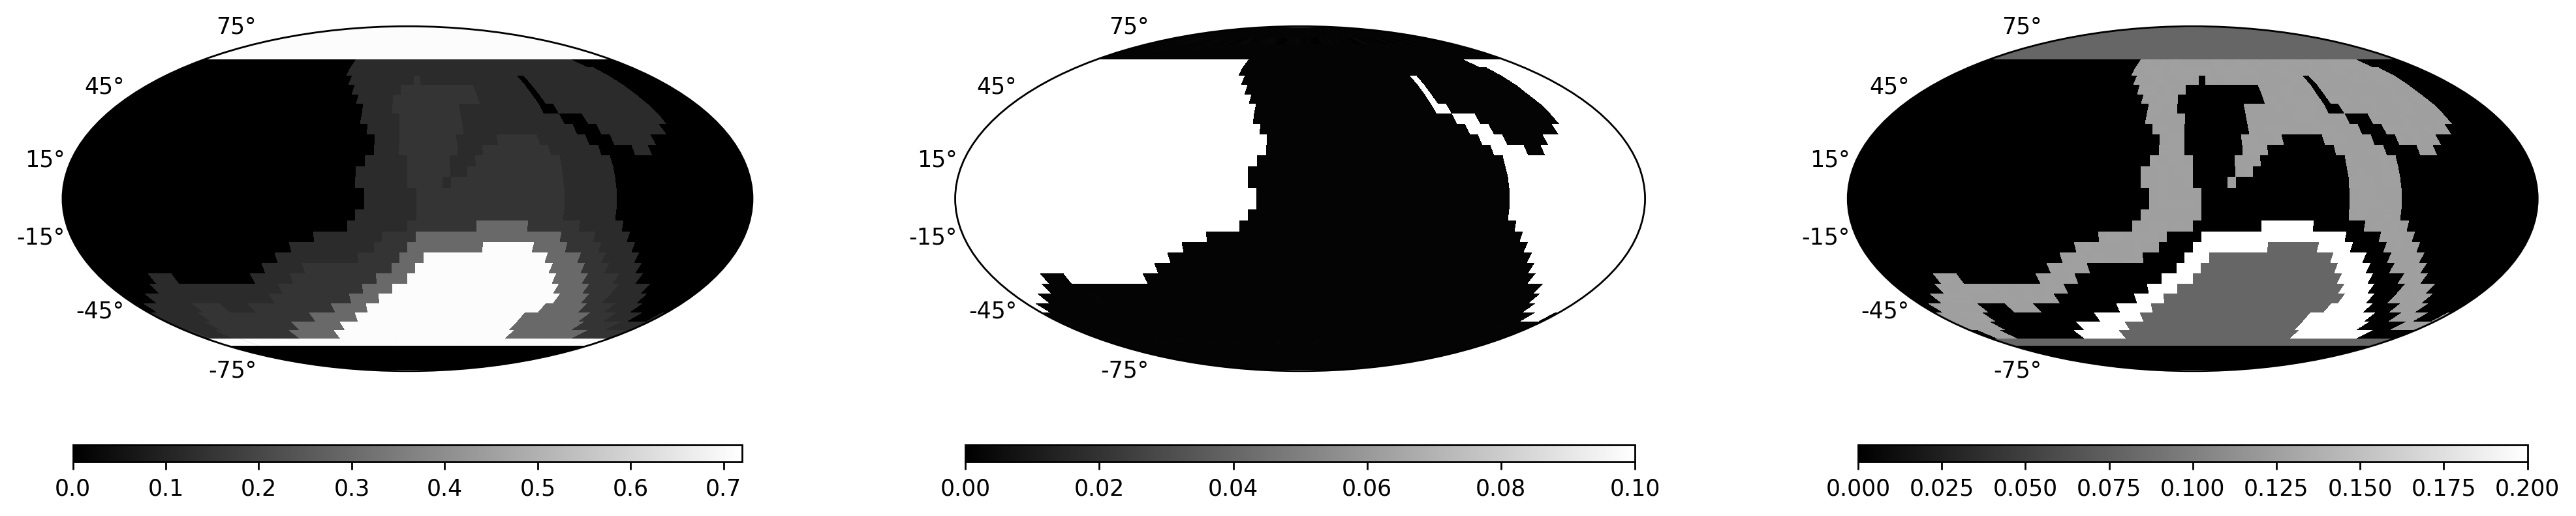

In [11]:
#nieuwe code

%matplotlib inline

Tcomp = np.concatenate((Tlambv,Tglintv,Tseelv),axis = 1)

SVCR = 1e-10

Tcomp_pinv_edge = np.linalg.pinv(Tcomp, rcond = SVCR)

print('SVCR' ,SVCR)
Acomp_edge = np.matmul(Tcomp_pinv_edge, f_total)

A_lamb = Acomp_edge[:2*res*res]
A_glint = Acomp_edge[2*res*res:2*2*res*res]
A_seel = Acomp_edge[2*2*res*res:]

lamb_factor = 0.8*0.9/(max(A_lamb)-min(A_lamb))
seel_factor = 0.5*0.4/(max(A_seel)-min(A_seel))
glint_factor = 0.1/(max(A_glint)-min(A_glint))

A_lamb_scaled = (A_lamb-min(A_lamb))*lamb_factor
A_glint_scaled = (A_glint-min(A_glint))*glint_factor
A_seel_scaled = (A_seel-min(A_seel))*seel_factor


reconstruct_A_lamb_scaled = A_lamb_scaled.reshape((res,2*res),order = 'F')
reconstruct_A_glint_scaled = A_glint_scaled.reshape((res,2*res),order = 'F')
reconstruct_A_seel_scaled = A_seel_scaled.reshape((res,2*res),order = 'F')


albedo_map_grid = reconstruct_A_lamb_scaled
ocean_map_grid = reconstruct_A_glint_scaled
seeliger_map_grid = reconstruct_A_seel_scaled

#plot albedo specular and seeliger maps together


shrink = 0.9

newgistearth = cm.get_cmap('gist_earth', 4096)
newcolors = np.vstack((newgistearth(np.linspace(0,0.35,256)), newgistearth(np.linspace(0.45,1,256))))
newcmp = ListedColormap(newcolors)

albedo_colors = np.vstack((newgistearth(np.linspace(0.15,0.22,100)), newgistearth(np.linspace(0.45,0.55,200)),newgistearth(np.linspace(0.6,0.7,200)),newgistearth(np.linspace(0.7,0.8,200)), newgistearth(np.linspace(0.95,1,400))))
albedo_cmp = ListedColormap(albedo_colors)
albedo_colors1 = np.vstack((newgistearth(np.linspace(0.15,0.22,140)), newgistearth(np.linspace(0.45,0.55,180)),newgistearth(np.linspace(0.6,0.7,200)),newgistearth(np.linspace(0.7,0.8,280)), newgistearth(np.linspace(0.95,1,400))))
albedo_cmp1 = ListedColormap(albedo_colors1)

lon = np.linspace(-np.pi,np.pi,2*res)
lat = np.linspace(-np.pi/2,np.pi/2,res)
Lon,Lat = np.meshgrid(lon,lat)

fig1 = plt.figure(1, figsize = (20,4), dpi = 250)
ax1 = fig1.add_subplot(131, projection = 'mollweide')
ax2 = fig1.add_subplot(132, projection = 'mollweide')
ax3 = fig1.add_subplot(133, projection = 'mollweide')

ax1.title.set_text('')
ax2.title.set_text('')
ax3.title.set_text('')


im1 = ax1.pcolormesh(Lon,Lat, np.flipud(albedo_map_grid),cmap = 'gray')
plt.colorbar(im1,shrink = shrink, aspect=40,ax = ax1,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax1.set_xticklabels(tick_labels, fontsize = '10')
ax1.set_yticklabels(tick_labels_y, fontsize = '10')

im2 = ax2.pcolormesh(Lon,Lat, np.flipud(ocean_map_grid),cmap = 'gray')
plt.colorbar(im2,shrink = shrink, aspect=40,ax = ax2,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax2.set_xticklabels(tick_labels, fontsize = '10')
ax2.set_yticklabels(tick_labels_y, fontsize = '10')

     
im3 = ax3.pcolormesh(Lon,Lat, np.flipud(seeliger_map_grid),cmap = 'gray')
plt.colorbar(im3,shrink = shrink, aspect=40, ax = ax3,orientation = 'horizontal')
tick_labels = np.array([])
tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
ax3.set_xticklabels(tick_labels, fontsize = '10')
ax3.set_yticklabels(tick_labels_y, fontsize = '10')
                   
                                         
             
plt.show()


In [12]:
# print('busy plotting')
# '''
# create corresponding meshgrid
# '''

# %matplotlib widget
# albedo_map_grid = albedo_pseudo_grid

# newgistearth = cm.get_cmap('gist_earth', 4096)
# newcolors = np.vstack((newgistearth(np.linspace(0,0.35,256)), newgistearth(np.linspace(0.45,1,256))))
# newcmp = ListedColormap(newcolors)

# albedo_colors = np.vstack((newgistearth(np.linspace(0.15,0.22,100)), newgistearth(np.linspace(0.45,0.55,200)),newgistearth(np.linspace(0.6,0.7,200)),newgistearth(np.linspace(0.7,0.8,200)), newgistearth(np.linspace(0.95,1,400))))
# albedo_cmp = ListedColormap(albedo_colors)
# albedo_colors1 = np.vstack((newgistearth(np.linspace(0.15,0.22,140)), newgistearth(np.linspace(0.45,0.55,180)),newgistearth(np.linspace(0.6,0.7,200)),newgistearth(np.linspace(0.7,0.8,280)), newgistearth(np.linspace(0.95,1,400))))
# albedo_cmp1 = ListedColormap(albedo_colors1)

# lon = np.linspace(-np.pi,np.pi,2*res)
# lat = np.linspace(-np.pi/2,np.pi/2,res)
# Lon,Lat = np.meshgrid(lon,lat)


# fig1 = plt.figure(1, figsize = (10,5))

# ax1 = fig1.add_subplot(111, projection = 'mollweide')
# ax1.title.set_text('Retrieved Lambertian Albedo')
# im1 = ax1.pcolormesh(Lon,Lat, np.flipud(albedo_map_grid),cmap = 'terrain')
# plt.colorbar(im1,shrink = 0.75, aspect=40)
# tick_labels = np.array(['-150°', '', '-90°','', '-30°', '', '30°', '','90°', '', '150°'])
# tick_labels_y = ['-75°', '', '-45°','', '-15°', '', '15°', '','45°', '', '75°']
             
# plt.show()